#Assignment 3-CUDA C++ Programming, Thrust Parallel Programming & RAPIDS
##Nmae: Tavishi Kashyap
##group: 2PA1

Q1. Write a CUDA C/C++ program to perform element-wise addi;on of two
vectors.

C[i]=A[i]+B[i]

Given: Vector size: N = 1024

In [5]:
%%writefile vector_add.cu
#include <stdio.h>

#define N 1024

__global__ void addVectors(int *A, int *B, int *C) {
    int i = threadIdx.x;   // thread index
    C[i] = A[i] + B[i];
}

int main() {
    int A[N], B[N], C[N];
    int *d_A, *d_B, *d_C;

    int size = N * sizeof(int);
    for (int i = 0; i < N; i++) {
        A[i] = i;
        B[i] = i;
    }


    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);


    cudaMemcpy(d_A, A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, size, cudaMemcpyHostToDevice);


    addVectors<<<1, N>>>(d_A, d_B, d_C);


    cudaMemcpy(C, d_C, size, cudaMemcpyDeviceToHost);


    for (int i = 0; i < 10; i++) {
        printf("C[%d] = %d\n", i, C[i]);
    }


    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    return 0;
}



Overwriting vector_add.cu


In [6]:
!nvcc -arch=sm_75 vector_add.cu -o vector_add  && ./vector_add

C[0] = 0
C[1] = 2
C[2] = 4
C[3] = 6
C[4] = 8
C[5] = 10
C[6] = 12
C[7] = 14
C[8] = 16
C[9] = 18


 2. Perform the same vector addition as in Q1 using Thrust library only

In [11]:
%%writefile thrust_add.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/transform.h>
#include <thrust/functional.h>

#define N 1024

int main() {


    thrust::device_vector<int> A(N);
    thrust::device_vector<int> B(N);
    thrust::device_vector<int> C(N);

    for (int i = 0; i < N; i++) {
        A[i] = i;
        B[i] = i;
    }

    // Perform C = A + B
    thrust::transform(A.begin(), A.end(),
                      B.begin(),
                      C.begin(),
                      thrust::plus<int>());


    for (int i = 0; i < 10; i++) {
        std::cout << "C[" << i << "] = " << C[i] << std::endl;
    }

    return 0;
}


Overwriting thrust_add.cu


In [12]:
!nvcc -arch=sm_75 thrust_add.cu -o thrust_add  && ./thrust_add

C[0] = 0
C[1] = 2
C[2] = 4
C[3] = 6
C[4] = 8
C[5] = 10
C[6] = 12
C[7] = 14
C[8] = 16
C[9] = 18


Q3. Compute the dot product of two vectors of size, N =1024:

 Result=∑A[i]×B[i]
using Thrust and compare its performance with that on CPU.

In [15]:
%%writefile dot_product.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/inner_product.h>

#define N 1024

int main() {
    // ----- CPU vectors -----
    int A[N], B[N];

    for (int i = 0; i < N; i++) {
        A[i] = i;
        B[i] = i;
    }

    // ----- CPU dot product -----
    int cpu_result = 0;
    for (int i = 0; i < N; i++) {
        cpu_result += A[i] * B[i];
    }

    // ----- GPU using Thrust -----
    thrust::device_vector<int> d_A(A, A + N);
    thrust::device_vector<int> d_B(B, B + N);

    int gpu_result = thrust::inner_product(
        d_A.begin(), d_A.end(),
        d_B.begin(),
        0);

    // ----- Results -----
    std::cout << "CPU Dot Product: " << cpu_result << std::endl;
    std::cout << "GPU Dot Product (Thrust): " << gpu_result << std::endl;

    return 0;
}


Overwriting dot_product.cu


In [16]:
!nvcc -arch=sm_75 dot_product.cu -o dot_product  && ./dot_product

CPU Dot Product: 357389824
GPU Dot Product (Thrust): 357389824


Q4. Write a CUDA kernel for matrix multiplication: C=A×B

where Matrix size is 16
X 16.

Explain why matrix mul;plica;on needs more computa;on than
addi;on (as in Q1)

In [17]:
%%writefile matrix_mul.cu
#include <stdio.h>

#define N 16

// CUDA kernel
__global__ void matrixMul(int *A, int *B, int *C) {
    int row = threadIdx.y;
    int col = threadIdx.x;

    int sum = 0;

    for (int k = 0; k < N; k++) {
        sum += A[row * N + k] * B[k * N + col];
    }

    C[row * N + col] = sum;
}

int main() {
    int A[N][N], B[N][N], C[N][N];
    int *d_A, *d_B, *d_C;

    int size = N * N * sizeof(int);

    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            A[i][j] = 1;
            B[i][j] = 1;
        }
    }

    cudaMalloc(&d_A, size);
    cudaMalloc(&d_B, size);
    cudaMalloc(&d_C, size);

    cudaMemcpy(d_A, A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, size, cudaMemcpyHostToDevice);

    // Launch kernel (1 block, 16x16 threads)--------
    dim3 threads(N, N);
    matrixMul<<<1, threads>>>(d_A, d_B, d_C);

    cudaMemcpy(C, d_C, size, cudaMemcpyDeviceToHost);


    printf("First few results:\n");
    for (int i = 0; i < 4; i++) {
        printf("%d ", C[0][i]);
    }


    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    return 0;
}

Writing matrix_mul.cu


In [18]:
!nvcc -arch=sm_75 matrix_mul.cu -o matrix_mul  && ./matrix_mul

First few results:
16 16 16 16 

Q5. For vector addi;on of size 5,000,000, implement and compare:

• CPU sequential C/C++ program

• CUDA kernel implementation

• Thrust implementation

• RAPIDS implementation

Measure execution time and compare complexity for each approach and
present results in a table. Plot comparison graph.

In [45]:

%%writefile cpu_add.cpp
#include <iostream>
#include <chrono>
#include <vector>


//CPU sequential

#define N 5000000

int main() {

    std::vector<float> A(N, 1.0f);
    std::vector<float> B(N, 2.0f);
    std::vector<float> C(N);

    auto start = std::chrono::high_resolution_clock::now();

    // CPU addition
    for (int i = 0; i < N; i++) {
        C[i] = A[i] + B[i];
    }

    auto end = std::chrono::high_resolution_clock::now();
    double time = std::chrono::duration<double, std::milli>(end - start).count();

    std::cout << "CPU Time (ms): " << time << std::endl;
    std::cout << "C[0] = " << C[0] << std::endl;

    return 0;
}



Overwriting cpu_add.cpp


In [46]:
!nvcc -arch=sm_75 cpu_add.cpp -o cpu_add  && ./cpu_add

CPU Time (ms): 36.2559
C[0] = 3


In [47]:
%%writefile cuda_add.cu
#include <iostream>
#include <cuda_runtime.h>

//CUDA kernel implementation


#define N 5000000

__global__ void add(float *A, float *B, float *C) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N)
        C[i] = A[i] + B[i];
}

int main() {
    float *A, *B, *C;
    float *d_A, *d_B, *d_C;
    int size = N * sizeof(float);

    A = (float*)malloc(size);
    B = (float*)malloc(size);
    C = (float*)malloc(size);

    for (int i = 0; i < N; i++) {
        A[i] = 1.0f;
        B[i] = 2.0f;
    }

    cudaMalloc(&d_A, size);
    cudaMalloc(&d_B, size);
    cudaMalloc(&d_C, size);

    cudaMemcpy(d_A, A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, size, cudaMemcpyHostToDevice);

    int threads = 256;
    int blocks = (N + threads - 1) / threads;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    add<<<blocks, threads>>>(d_A, d_B, d_C);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float ms;
    cudaEventElapsedTime(&ms, start, stop);

    cudaMemcpy(C, d_C, size, cudaMemcpyDeviceToHost);

    std::cout << "CUDA Time (ms): " << ms << std::endl;
    std::cout << "C[0] = " << C[0] << std::endl;

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
    free(A);
    free(B);
    free(C);

    return 0;
}



Overwriting cuda_add.cu


In [48]:
!nvcc -arch=sm_75 cuda_add.cu -o cuda_add  && ./cuda_add

CUDA Time (ms): 0.276416
C[0] = 3


In [63]:
%%writefile thrust_add.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/transform.h>
#include <thrust/functional.h>
#include <cuda_runtime.h>

#define N 5000000

int main() {

    thrust::device_vector<float> A(N, 1.0f);
    thrust::device_vector<float> B(N, 2.0f);
    thrust::device_vector<float> C(N);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    // Vector addition: C = A + B-------------
    thrust::transform(A.begin(), A.end(),
                      B.begin(),
                      C.begin(),
                      thrust::plus<float>());

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);

=
    std::cout << "Thrust Time (ms): " << ms << std::endl;
    std::cout << "C[0] = " << C[0] << std::endl;

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return 0;
}


Overwriting thrust_add.cu


In [64]:
!nvcc -arch=sm_75 thrust_add.cu -o thrust_add && ./thrust_add

Thrust Time (ms): 0.266624
C[0] = 3


In [54]:
import time
import cupy as cp
import cudf

N = 5_000_000

a = cudf.Series(cp.ones(N, dtype=cp.float32))
b = cudf.Series(cp.ones(N, dtype=cp.float32) * 2)

cp.cuda.Stream.null.synchronize()
t1 = time.perf_counter()

c = a + b

cp.cuda.Stream.null.synchronize()
t2 = time.perf_counter()

ms = (t2 - t1) * 1000
print("RAPIDS_ms", ms)
print("check", float(c.iloc[0]))

RAPIDS_ms 1.2956370001120376
check 3.0


In [65]:
import pandas as pd

data = {
    'Method': ['CPU', 'CUDA', 'THRUST', 'RAPIDS'],
    'Time (ms)': [36.2559,  0.276416 ,  0.266624 ,1.2956],
    'Complexity': ['O(N)', 'O(N)', 'O(N)', 'O(N)']
}

df = pd.DataFrame(data)
display(df)

,Method,Time (ms),Complexity
0,CPU,36.255900,O(N)
1,CUDA,0.276416,O(N)
2,THRUST,0.266624,O(N)
3,RAPIDS,1.295600,O(N)



RESULTS TABLE:

Method  Time (ms) Complexity
   CPU  36.255900       O(N)
  CUDA   0.276416       O(N)
THRUST   0.266624       O(N)
RAPIDS   1.295600       O(N)


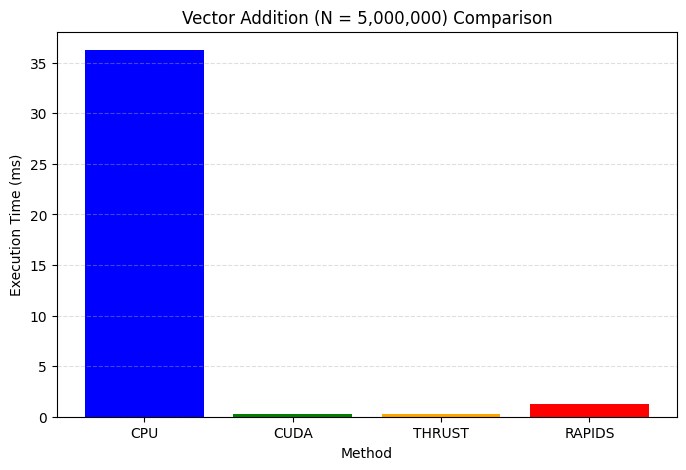

In [66]:
import pandas as pd
import matplotlib.pyplot as plt


print("\nRESULTS TABLE:\n")
print(df.to_string(index=False))

plt.figure(figsize=(8, 5))
plt.bar(df["Method"], df["Time (ms)"], color=['blue', 'green', 'orange', 'red'])
plt.xlabel("Method")
plt.ylabel("Execution Time (ms)")
plt.title("Vector Addition (N = 5,000,000) Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

Q6. Write a CUDA C++ program using the Thrust library to compute the sum of
all elements in a vector stored on the GPU. The vector is of size 10 and it
should be ini;alized with values 1,…..10.

In [40]:
%%writefile thrust_reduce.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/reduce.h>

int main() {
    const int N = 10;


    thrust::device_vector<int> vec(N);


    for (int i = 0; i < N; i++) {
        vec[i] = i + 1;
    }


    int sum = thrust::reduce(vec.begin(), vec.end());


    std::cout << "Sum = " << sum << std::endl;

    return 0;
}



Overwriting thrust_reduce.cu


In [41]:
!nvcc -arch=sm_75 thrust_reduce.cu -o thrust_reduce && ./thrust_reduce

Sum = 55


Q7. Write a CUDA C++ program using Thrust to sort (ascending) a vector of
integers on the GPU. Consider vector size 8 with following values: 7, 2, 9, 1,
5, 3, 8, 4. Print the vector before and afer sor;ng.

In [43]:
%%writefile thrust_sort.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/sort.h>
#include <thrust/copy.h>

int main() {

    int arr[8] = {7, 2, 9, 1, 5, 3, 8, 4};


    thrust::device_vector<int> vec(arr, arr + 8);


    std::cout << "Before sorting: ";
    for (int i = 0; i < 8; i++) {
        std::cout << vec[i] << " ";
    }
    std::cout << std::endl;

    // Sorting in ascending order------------
    thrust::sort(vec.begin(), vec.end());


    std::cout << "After sorting: ";
    for (int i = 0; i < 8; i++) {
        std::cout << vec[i] << " ";
    }
    std::cout << std::endl;

    return 0;
}

Writing thrust_sort.cu


In [44]:
!nvcc -arch=sm_75 thrust_sort.cu -o thrust_sort && ./thrust_sort

Before sorting: 7 2 9 1 5 3 8 4 
After sorting: 1 2 3 4 5 7 8 9 
